## Importing Modules :

In [64]:
# installing optax and flax in colab! for optimization
from jax.config import config
config.update("jax_enable_x64", True)  #double precision


In [78]:
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# from matplotlib import style

# fig = plt.figure()
# ax1 = fig.add_subplot(1,1,1)

In [74]:
import jax.numpy as jnp

from skopt.space import Space
from skopt.sampler import Halton
from jax import jacfwd

# Special Transform Functions
from jax import grad, jit, vmap, pmap
import jax
from jax import jit

from jax._src.lax.utils import (
    _argnum_weak_type,
    _input_dtype,
    standard_primitive,)
from jax._src.lax import lax
from itertools import count
index = count()
from tqdm import tqdm, trange
import prk_for_optimization as IRK4


# Functions :

In [75]:
def One_Dim_Matrix(A):
    """
    We use this function to convert a 2D array into a 1D array containing only the lower triangular matrix of the 2D array.
    : param A : a 2D array
    : return : a 1D array

    """
    dim_x, dim_y = A.shape
    #print(dim_x, dim_y)
    A = A.reshape(1, (dim_x * dim_y))
    return A


def Add_B_tomatrix_A(A, b):
    """
    Given 2 1D arrays this function appends the second array at the end of first array.
    : param A : 1D array
    : param b : 1D array
    : return : 1D array after appending array b to A

    """
    A = jnp.append(A,b)
    return A


def Aminus(M, dr):
    """
    THis function subtracts dr from M and then return the updated value of M
    : param M : 1D array
    : param dr : 1D array
    : return : 1D array after subtracting dr from M

    """

    M = M, dr
    return M


def Aplus(M, dr):
    """
    THis function add dr to M and then return the updated value of M
    : param M : 1D array
    : param dr : 1D array
    : return : 1D array after adding dr to M

    """

    M = jnp.add(M, dr)
    return M


def actual_A_1D(A):
    """
    This function takes in a 1D array and breaks it into 2 arrays.
    : param A : 1D array
    : return A_new : 1D array of length = 10
    : return b1 : 1D array of length = 4

    """

    b1 = A[16:20]
    A_new = A[0:16]
    return A_new, b1


def actual_A1_A2(A): # from the returned gradient array of 20 elements, we find the elements of array A and array B
                    # first 16 elemets belong to lower triangular elements of array A and 4 belongs to B
    A1 = A[0:20]
    A2 = A[20:40]
    H_sequence = A[40:]
    return A1, A2, H_sequence


def One_D_to_TwoD(A):
    """
    Using a 1D array, returned by the function @actual_A_1D , making a lower triangular matrix A2D
    : param A : 1D array of length = 10
    : return : 2D array

    """
    A = A.reshape(4, 4)
    return A

"""
 : using the initial matrix A and B from the source given below :
 : wiki link : https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods#:~:text=is%5B13%5D-,0,1/6,-A%20slight%20variation
"""
# Lobatto IIIA and IIIB fourth-order
"""
A1 = jnp.array([
     [0., 0., 0., 0.],
     [5/24, 1/3, -1/24, 0.],
     [1/6, 2/3, 1/6, 0.],
     [0., 0., 0., 0.]])
B1 = jnp.array([1/6, 2/3, 1/6, 0.])

A2 = jnp.array([
     [1/6, -1/6, 0., 0.],
     [1/6, 1/3, 0., 0.],
     [1/6, 5/6, 0., 0.],
     [0., 0., 0., 0.]])
B2 = jnp.array([1/6, 2/3, 1/6, 0.])
"""

# A1 = jnp.array([
#      [-3.79785958e-04, -3.67738916e-04, -3.66609733e-04, -3.54059498e-04],
#      [4.99588868e-01, -3.98680865e-04, -3.97527769e-04, -3.84584355e-04],
#      [-4.11173512e-04, 4.99601272e-01, -3.97592005e-04, -3.84671344e-04],
#      [-4.81541825e-04, -4.68739061e-04, 9.99532432e-01, -4.54287566e-04]])

# A2 = jnp.array([
#      [-3.11736027e-04, -2.94485578e-04, -2.93712618e-04, -2.76140987e-04],
#      [4.99655359e-01, -3.27464211e-04, -3.26729921e-04, -3.09316939e-04],
#      [-3.47133596e-04, 4.99670006e-01, -3.29267572e-04, -3.11898479e-04],
#      [-3.40012311e-04, -3.23224123e-04, 9.99677453e-01, -3.05624000e-04]])

# B1 = jnp.array([0.16600046, 0.33204984, 0.33202047, 0.16260358])
# B2 = jnp.array([0.16641716, 0.33222953, 0.33218721, 0.16210258])


A1 = A2 = jnp.array([
     [0., 0., 0., 0.],
     [1/2, 0., 0., 0.],
     [0., 1/2, 0., 0.],
     [0., 0., 1.0, 0.]])


B1 = B2 = jnp.array([1/6, 1/6, 2/3, 1/6])


## Lobatto IIIB methods are A-stable, but not L-stable and B-stable.


## Making the Halton code

spacedim = [(-0.5, 1.),(-0.5, 1.),(-0.5, 1.),(-0.5, 1.),(-0.5, 1.),(-0.5, 1.) ]

space = Space(spacedim)

halton = Halton()
n = 10

halton_sequence = halton.generate(space, n)
halton_sequence = jnp.array(halton_sequence)


## ADAgrad using optax

In [76]:
# Initial A1D

A1D = One_Dim_Matrix(A1)
A1D = Add_B_tomatrix_A(A1D, B1)

A2D = One_Dim_Matrix(A2)
A2D = Add_B_tomatrix_A(A2D, B2)

A1D = Add_B_tomatrix_A(A1D, A2D)

print(A1D.shape)

import optax

learning_rate = 0.01
list_optimizers = [optax.adam(learning_rate)]
# chosing Stochastic Gradient Descent Algorithm.
# We have created a list here keeping in mind that we may apply all the optimizers in optax by storing their objects in the list

opt_sgd = list_optimizers[0]
opt_state = opt_sgd.init(A1D)
# print(opt_state)

params = A1D
repetetion = 100

# error_list = jnp.zeros((len(halton_sequence)*repetetion,))

error_list_1 = []
error_list_2 = []

count = 0
for i in range(100):
  #A1D = Add_B_tomatrix_A(A1D, halton_sequence[i])
  import jax.numpy as jnp



  for epoch in trange(repetetion):
    # print(epoch)
    """
    rk4 = jit(IRK4.find_error)
    grad = jax.grad(rk4)
    """
    # print("=======", A1D.shape)
    grad = jacfwd(IRK4.find_error)
    gradF = grad(A1D, halton_sequence[i])
    # print(gradF)

    updates, opt_state = opt_sgd.update(gradF, opt_state)

    A1D = optax.apply_updates(A1D, updates)
    # print("=======", A1D.shape)
    # print(gradF)
    A1D = A1D.reshape(40, )

    # eror = IRK4.find_error(A1D, halton_sequence[i])
    # print(eror)
    # error_list  = error_list.at[count].set(eror)
    # print(A1D)

    # count += 1
  eror = IRK4.find_error(A1D, halton_sequence[i])
  error_list_2.append(eror)

A1D = A1D[:40]

(40,)


  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:22<02:33,  1.76s/it]


KeyboardInterrupt: 

In [ ]:
print(error_list_2)

In [ ]:
new_A1, new_b1 = actual_A_1D(A1D[0:20])
new_A2, new_b2 = actual_A_1D(A1D[20:40])

#converting A to a 2D Array
new_A1 = One_D_to_TwoD(new_A1)
new_A2 = One_D_to_TwoD(new_A2)

print(new_A1)
print(new_A2)

In [ ]:
print(error_list_2)
print(new_b1)
print(new_b2)

In [ ]:
import matplotlib.pyplot as plt
a = list(range(1,len(error_list_2)+1))
print(a[0])

# Convergence
plt.loglog(a, error_list_2, label = "Error",marker='o')

# plt.plot(step_size_list_convergence, error_list_convergence, label = "Error",marker='o')
plt.legend()
plt.grid()
plt.xlabel('Halton Sequence')
plt.ylabel('Log Error')

# Now applying the updated value to the PRK method, and checking the convergence

In [53]:

# RK4 4th order Table

A1 = A2 = jnp.array([
     [0., 0., 0., 0.],
     [1/2, 0., 0., 0.],
     [0., 1/2, 0., 0.],
     [0., 0., 1.0, 0.]])


B1 = B2 = jnp.array([1/6, 1/3, 1/3, 1/6])

print(A1.shape)
print(B1.shape)

# A1 = new_A1
# A2 = new_A2

# B1 = new_b1
# B2 = new_b2

@jit
def f(y, z):
    return z
@jit
def g(y, z):
    return -y


def Energy_Function(y, z):
    return (jnp.square(y) + jnp.square(z))/2

@jit
def PRK_step(y0 , z0, h, A1, A2, B1, B2):
    s = A1.shape[0]
    dim = jnp.size(y0)
    tol = 10**(-10)
    K_old = jnp.zeros((s,dim))
    L_old = jnp.zeros((s,dim))

    K_new = f((y0+ h*A1 @ K_old), (z0+ h*A2 @ L_old))
    L_new = g((y0+ h*A1 @ K_old), (z0+ h*A2 @ L_old))

    init_state = 0, K_new, L_new, K_old, L_old
    
    @jit
    def body_while_loop(state):
        _, K_new, L_new, K_old, L_old = state
        K_old = K_new
        L_old = L_new
        K_new = f(y0+ h * A1 @ K_old, z0 + h * A2 @ L_old)
        L_new = g(y0+ h * A1 @ K_old, z0 + h * A2 @ L_old)

        return _, K_new, L_new, K_old, L_old
    
    @jit
    def condition_while_loop(state):
        _, K_new, L_new, K_old, L_old = state
        norms = jnp.sum(jnp.array([jnp.linalg.norm(K_new - K_old) + jnp.linalg.norm(L_new - L_old)]))
        return norms > tol

    _, K_new, L_new, K_old, L_old = jax.lax.while_loop(condition_while_loop, body_while_loop, init_state)
    yn = y0 + h * B1 @ K_new
    zn = z0 + h * B2 @ L_new

    return yn, zn

if __name__ == "__main__":
    time_factor = 1 # default

    y0 = jnp.zeros((1,1))
    z0 = jnp.ones((1,1))

    NN = jnp.array([1, 10, 100, 1000])
    istep = 10
    step_size_list_convergence = []
    o_error_list_convergence = []
    c_error_list_convergence = []


    for i in range(len(NN)):
        yn_list = jnp.zeros((time_factor * NN[i], 1))
        zn_list = jnp.zeros((time_factor * NN[i], 1))
        iyn_list = jnp.zeros((time_factor * istep * NN[i] , 1))
        izn_list = jnp.zeros((time_factor * istep * NN[i] , 1))


        yn = zn = iyn = izn = []
        h = time_factor/NN[i] #step size
        y = iy = y0
        z = iz = z0

        
        def fori_loop_1(i, state):
            yn_list, zn_list, y, z, A1, A2, B1, B2 = state
            y, z = PRK_step(y, z, h, A1, A2, B1, B2)
            yn_list = yn_list.at[i].set(y.ravel())
            zn_list = zn_list.at[i].set(z.ravel())
            state = yn_list, zn_list, y, z, A1, A2, B1, B2

            return state
        init_state_yz = yn_list, zn_list, y, z, A1, A2, B1, B2
        yn_list, zn_list, _, _, _, _, _, _ = jax.lax.fori_loop(0, time_factor * NN[i], fori_loop_1, init_state_yz)

        @jit
        def fori_loop_2(j, state):
            iyn_list, izn_list, iy, iz, A1, A2, B1, B2 = state
            iy, iz = PRK_step(iy, iz, h/istep, A1, A2, B1, B2)
            iyn_list = iyn_list.at[j].set(iy.ravel())
            izn_list = izn_list.at[j].set(iz.ravel())
            state = iyn_list, izn_list, iy, iz, A1, A2, B1, B2

            return state
        init_state_iyz = iyn_list, izn_list, iy, iz, A1, A2, B1, B2
        iyn_list, izn_list, _, _, _, _, _, _ = jax.lax.fori_loop(0, time_factor * istep * NN[i], fori_loop_2, init_state_iyz) # time istep
        j1_iyn_list = iyn_list[9:time_factor*istep*NN[i]:10]
        j2_izn_list = izn_list[9:time_factor*istep*NN[i]:10]


        # this is for calculating the original error
        tt1 =  jnp.linspace(h, 1, NN[i]*time_factor)
        sine_value = jnp.sin(tt1)
        cosine_value = jnp.cos(tt1)


        # Finding error using original Value

        err1 = yn_list.ravel() - sine_value #(yn_list, sine_value)
        err2 = zn_list.ravel() - cosine_value #(zn_list, cosine_value)

        original_error = jnp.sqrt((jnp.sum(jnp.square(err1))   ) / ( NN[i]))

        o_error_list_convergence.append(original_error)
        """   """
        # Finding error using original Value

        #### Calculating error with the smaller steps :

        print("======")
        print(j1_iyn_list.shape)
        print(yn_list.shape)
        print("======")

        err1 = j1_iyn_list.ravel() - yn_list.ravel()
        err2 = j2_izn_list.ravel() - zn_list.ravel()

        final_error = (jnp.sum(jnp.abs(err1)) + jnp.sum(jnp.abs(err2))) / (2*NN[i])

        #### Calculating error with the smaller steps :

        c_error_list_convergence.append(final_error)

        step_size_list_convergence.append(h)






(4, 4)
(4,)
(1, 1)
(1, 1)
(10, 1)
(10, 1)
(100, 1)
(100, 1)
(1000, 1)
(1000, 1)


Text(0, 0.5, 'Log Error')

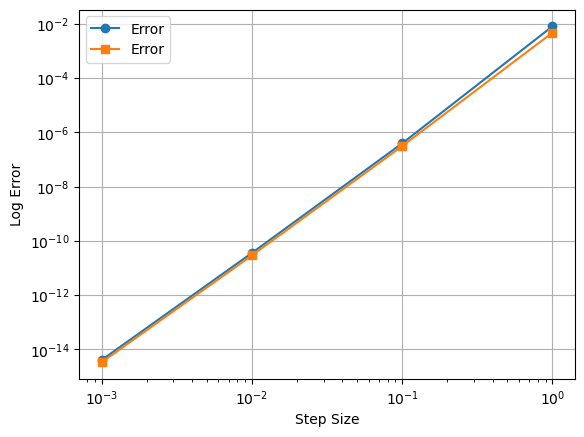

In [54]:
import matplotlib.pyplot as plt

# log_step_size_list_convergence = np.log(step_size_list_convergence)/np.log(10)
# log_error_list_convergence = np.log(error_list_convergence)/np.log(10)

# Convergence
plt.loglog(step_size_list_convergence, o_error_list_convergence, label = "Error",marker='o')
plt.loglog(step_size_list_convergence, c_error_list_convergence, label = "Error",marker='s')

# plt.plot(step_size_list_convergence, error_list_convergence, label = "Error",marker='o')
plt.legend()
plt.grid()
plt.xlabel('Step Size')
plt.ylabel('Log Error')

1000


Text(0, 0.5, 'x')

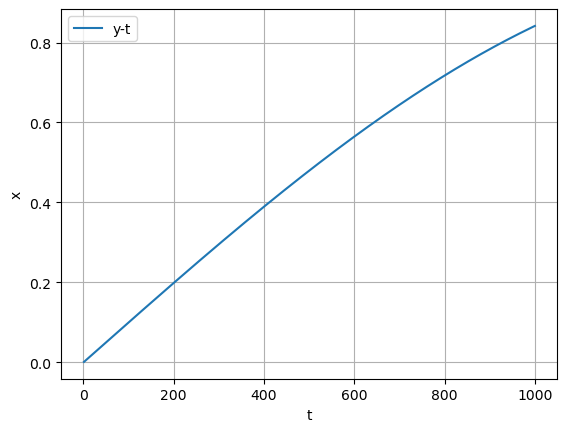

In [58]:
t2 = jnp.arange(1, 1001, 1)
plt.plot(t2, yn_list, label = "y-t", )
plt.legend()
plt.grid()
plt.xlabel('t')
plt.ylabel('x')
     

In [ ]:
t2 = jnp.arange(1, 1001, 1)
plt.plot(t2, zn_list, label = "z-t", )
plt.legend()
plt.grid()
plt.xlabel('t')
plt.ylabel('x')

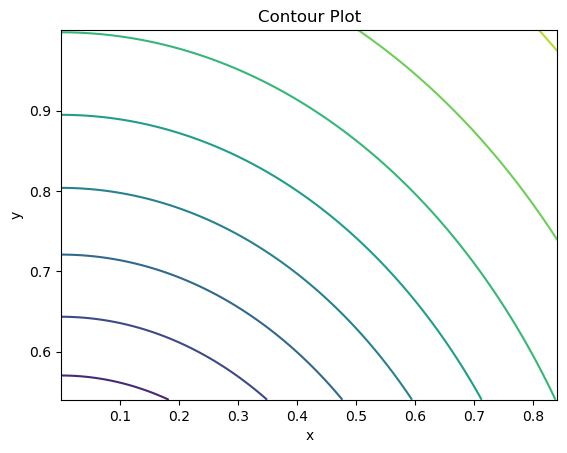

In [63]:
x = yn_list
x = x.flatten()
y = zn_list
y = y.flatten()
X, Y = jnp.meshgrid(x, y)
Z = jnp.sin(jnp.sqrt(X**2 + Y**2))

# Create the contour plot
plt.contour(X, Y, Z)
plt.title('Contour Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()